In [1]:
import numpy as np
from scipy.special import expit
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.infer.reparam import TransformReparam
from jax import random
import jax.numpy as jnp
import jax.scipy.special as jss
import arviz as az
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set()

In [4]:
npr.set_host_device_count(mp.cpu_count())

# Example from the doc

In [5]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [6]:
def eight_schools(J, sigma, y):
    
    mu = npr.sample('mu', dist.Normal(0, 5))
    tau = npr.sample('tau', dist.HalfCauchy(5))
    with npr.plate('J', J):
        with npr.handlers.reparam(config={'theta': TransformReparam()}):
            # theta = npr.sample('theta', dist.Normal(mu, tau))
            theta = npr.sample('theta',
                               dist.TransformedDistribution(dist.Normal(0., 1.),
                                                            dist.transforms.AffineTransform(mu, tau)))
    npr.sample('obs', dist.Normal(theta, sigma), obs=y)

In [7]:
nuts_kernel = NUTS(eight_schools)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=1, progress_bar=True)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, J, sigma, y=y)

sample: 100%|██████████| 1500/1500 [00:06<00:00, 232.86it/s, 7 steps of size 3.79e-01. acc. prob=0.91] 


In [8]:
mcmc.print_summary() 


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.07      3.49      3.95     -1.29     10.09    750.88      1.00
          tau      3.88      3.31      2.93      0.03      8.24    551.26      1.00
theta_base[0]      0.38      0.98      0.41     -1.30      1.83    775.55      1.00
theta_base[1]      0.13      0.94      0.16     -1.50      1.47   1245.81      1.00
theta_base[2]     -0.04      0.95     -0.03     -1.56      1.48    877.82      1.00
theta_base[3]      0.10      0.93      0.11     -1.46      1.61   1044.21      1.00
theta_base[4]     -0.10      0.94     -0.14     -1.73      1.32   1001.57      1.00
theta_base[5]     -0.10      0.93     -0.11     -1.65      1.44    902.72      1.00
theta_base[6]      0.38      0.97      0.38     -1.16      1.93    791.36      1.00
theta_base[7]      0.12      1.01      0.16     -1.68      1.58   1075.65      1.00

Number of divergences: 0


---

# Hierarchical model of forgetting

In [9]:
# def model(n_u, n_w, n_obs, u, w, d, r, y):

#     sg_w1 = npr.sample('sg_w1',  dist.InverseGamma(1, 1))
#     sg_u1 = npr.sample('sg_u1', dist.InverseGamma(1, 1))
#     sg_theta1 = npr.sample('sg_theta1', dist.InverseGamma(1, 1))
#     mu1 = npr.sample('mu1', dist.Normal(0, 10))

#     sg_w2 = npr.sample('sg_w2',  dist.InverseGamma(1, 1))
#     sg_u2 = npr.sample('sg_u2', dist.InverseGamma(1, 1))
#     sg_theta2 = npr.sample('sg_theta2', dist.InverseGamma(1, 1))
#     mu2 = npr.sample('mu2', dist.Normal(0, 10))
    
#     with npr.handlers.reparam(
#             config={'U1': TransformReparam(), 'U2': TransformReparam(),
#                     'W1': TransformReparam(), 'W2': TransformReparam(),}):
        
#         with npr.plate('users', n_u):

#             U1 = npr.sample('U1', 
#                             dist.TransformedDistribution(
#                                 dist.Normal(0., 1.),
#                                 dist.transforms.AffineTransform(0., sg_u1)))
#             U2 = npr.sample('U2', 
#                             dist.TransformedDistribution(
#                                 dist.Normal(0., 1.),
#                                 dist.transforms.AffineTransform(0., sg_u2)))

#         with npr.plate('words', n_w):
        
#             W1 = npr.sample('W1', 
#                             dist.TransformedDistribution(
#                                 dist.Normal(0., 1.),
#                                 dist.transforms.AffineTransform(0., sg_w1)))
#             W2 = npr.sample('W2', 
#                             dist.TransformedDistribution(
#                                 dist.Normal(0., 1.),
#                                 dist.transforms.AffineTransform(0., sg_w2)))

#         mu_theta1 = mu1 + U1[u] + W1[w]
#         mu_theta2 = mu2 + U2[u] + W2[w]

#         theta1 = npr.sample('theta1', 
#                        dist.TransformedDistribution(
#                             dist.Normal(0., 1.),
#                             [dist.transforms.AffineTransform(mu_theta1, sg_theta1),
#                              dist.transforms.ExpTransform()]))
#         theta2 = npr.sample('theta2',
#                        dist.TransformedDistribution(
#                             dist.Normal(0., 1.),
#                             [dist.transforms.AffineTransform(mu_theta2, sg_theta2),
#                              dist.transforms.SigmoidTransform()]))
        
#         logp = - theta1 * (1-theta2)**r * d
#         p = jnp.exp(logp)
#         logits = logp - jnp.log(1-p+jnp.finfo(float).eps)
#         npr.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [49]:
# class LogSum(npr.distributions.Distribution):
#     def __init__(self, p, *args, **kwargs):
#         self.p = p
#         super().__init__(batch_shape=(), event_shape=())

#     def log_prob(self, value):
#         return jnp.log(self.p**value*(1-self.p)**(1-value))
    
#     def _validate_sample(self, value):
#         return True

In [64]:
def model(n_u, n_w, n_obs, u, w, d, r, y):

    sg_w1 = npr.sample('sg_w1',  dist.InverseGamma(1, 1))
    sg_u1 = npr.sample('sg_u1', dist.InverseGamma(1, 1))
    sg_theta1 = npr.sample('sg_theta1', dist.InverseGamma(1, 1))
    mu1 = npr.sample('mu1', dist.Normal(0, 10))

    sg_w2 = npr.sample('sg_w2',  dist.InverseGamma(1, 1))
    sg_u2 = npr.sample('sg_u2', dist.InverseGamma(1, 1))
    sg_theta2 = npr.sample('sg_theta2', dist.InverseGamma(1, 1))
    mu2 = npr.sample('mu2', dist.Normal(0, 10))
        
    with npr.plate('users', n_u):

        U1 = npr.sample('U1', dist.Normal(0., sg_u1))
        U2 = npr.sample('U2', dist.Normal(0., sg_u2))

    with npr.plate('words', n_w):

        W1 = npr.sample('W1', dist.Normal(0., sg_w1))
        W2 = npr.sample('W2', dist.Normal(0., sg_w2))

    mu_theta1 = mu1 + U1[u] + W1[w]
    mu_theta2 = mu2 + U2[u] + W2[w]

    theta1 = npr.sample('theta1', dist.Normal(mu_theta1, sg_theta1))
    theta2 = npr.sample('theta2', dist.Normal(mu_theta2, sg_theta2))
    
    a = jnp.exp(theta1)
    b = dist.transforms.expit(theta2)
    
    logp = - a * (1-b)**r * d
    p = jnp.exp(logp) + jnp.finfo(float).eps
    # logits = logp - jnp.log(1-p+jnp.finfo(float).eps)
    # npr.sample('obs', LogSum(p), obs=y)
    npr.sample("obs", dist.Bernoulli(p), obs=y)

# Produce artificial data

## How does it look like?

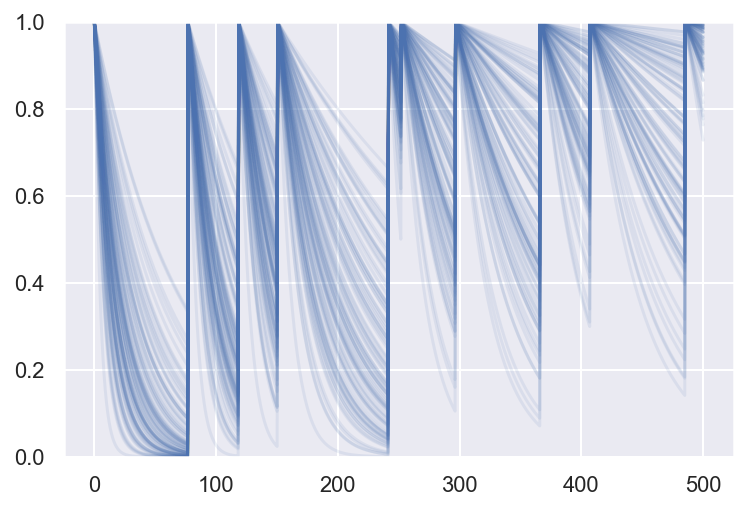

In [12]:
theta1 = np.random.normal(-3, 0.5, size=100)
theta2 = np.random.normal(-1, 0.4, size=100)

max_t = 5* 10**2
n_pres = 10

max_delay = 100

x = np.linspace(0, max_t, 1000)
pres = np.zeros(n_pres)
for i in range(1, n_pres):
    pres[i] = pres[i-1] + np.random.uniform(0, max_delay) 

n = np.zeros(x.shape)

delta = np.zeros(x.shape)
for i, p in enumerate(pres):
    delta[x>p] = x[x>p] - p
    n[x>p] = i
fig, ax = plt.subplots()

for th1, th2 in zip(theta1, theta2):
    alpha, beta = np.exp(th1), expit(th2)
    # print("alpha-beta", alpha, beta)
    p = np.exp(-alpha*(1-beta)**n*delta)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1);

## Create a batch

In [13]:
# Seed
np.random.seed(0)

# Parameterization
mu = -4, 0.3
sg_theta = 0.001, 0.001
sg_u = 0.1, 0.1
sg_w = 0.5, 0.3

n_u = 20         # Number of users
n_w = 10         # Number of words
n_o_max = 10     # Max. number of observations for one user
delta_max = 100  # Max. time delta between two presentations

n_w_by_u = np.random.randint(3, 5, n_u)                # Number of words seen by a single user
n_o_by_u = np.random.randint(n_o_max-2, n_o_max, n_u)  # Number of observations for a single user
n_obs = n_o_by_u.sum()                                 # Total number of observations

n_param = 2
U = np.random.normal(0, sg_u, size=(n_u, n_param))   # User ability
W = np.random.normal(0, sg_w, size=(n_w, n_param))   # Item difficulty

delta = np.random.uniform(0, delta_max, size=(n_u, n_o_max))

w = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
d = np.zeros(shape=n_obs, dtype=float)

idx = 0
for i_u in range(n_u):
    
    n_wu = n_w_by_u[i_u]
    n_ou = n_o_by_u[i_u]
    
    seen = np.random.choice(np.arange(n_w), replace=False, size=n_wu)
    w_u = np.random.choice(seen, replace=True, size=n_ou)
    counts = {word: 0 for word in seen}
    r_u = np.zeros(shape=n_ou, dtype=int)
    for i, word in enumerate(w_u):
        r_u[i] = counts[word]
        counts[word] += 1
    
    d_u = delta[i_u, :n_ou]
    
    d[idx:idx+n_ou] = d_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou
    
mu_obs = mu + U[u] + W[w]
theta = np.random.normal(mu_obs, sg_theta)
a = np.exp(theta[:, 0])
b = expit(theta[:, 1])
exponent = - a *(1-b)**r * d
p = np.exp(exponent)
rd = np.random.normal(size=n_obs)
y = (p > rd).astype(int)

In [14]:
data_artificial = {'n_u': n_u, 'n_w': n_w, 'n_obs': n_obs, 
                   'u': u, 'w': w, 
                   'd': d, 'r': r,
                   'y': y}

In [15]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.6418018279191142 0.9971788617119843 0.040728604324842516
0.7790697674418605 0 1


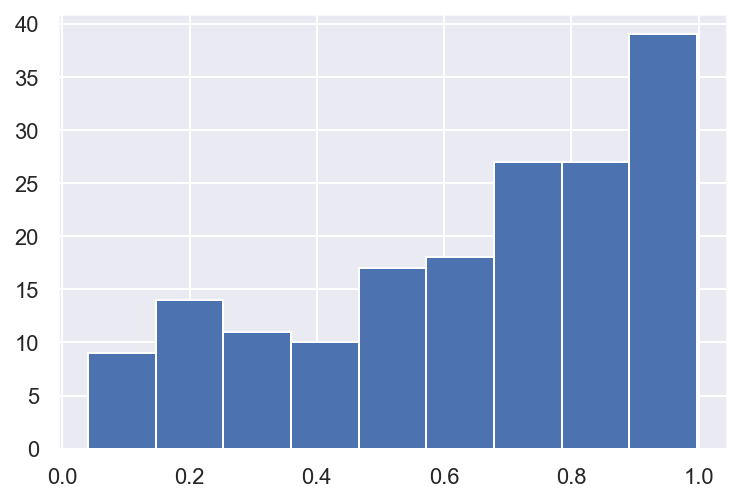

In [16]:
plt.hist(p, bins='auto');

In [17]:
np.abs(p-y).mean()

0.3806294860149697

# Run with artificial data

In [18]:
%%time
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, **data_artificial)

[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1]
[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1]


  0%|          | 0/4000 [00:00<?, ?it/s]

[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1]


warmup:   0%|          | 1/4000 [00:07<7:48:58,  7.04s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1]


sample: 100%|██████████| 4000/4000 [00:50<00:00, 79.35it/s, 81 steps of size 1.92e-02. acc. prob=0.71]   


CPU times: user 55.9 s, sys: 1.44 s, total: 57.3 s
Wall time: 53.7 s


In [19]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      U1[0]      1.27      3.01      0.50     -2.25      7.10     51.14      1.06
      U1[1]      0.51      2.37      0.32     -3.08      5.26     99.72      1.00
      U1[2]     -0.02      2.69      0.01     -3.94      5.47     80.53      1.04
      U1[3]      1.68      3.16      0.80     -1.98      7.47     35.99      1.00
      U1[4]      1.11      2.70      0.41     -2.83      5.68     81.19      1.01
      U1[5]     -0.02      2.52     -0.05     -3.69      4.84    138.42      1.01
      U1[6]     -1.20      3.17     -0.44     -6.53      2.97     72.42      1.08
      U1[7]     -1.56      3.19     -0.72     -7.10      2.88     58.25      1.06
      U1[8]      0.89      2.40      0.34     -2.67      4.65     59.49      1.00
      U1[9]     -1.88      3.17     -0.79     -7.78      1.52     41.46      1.06
     U1[10]      0.09      2.14      0.05     -3.52      3.50    227.33      1.01
     U1[11]    

Number of divergences: 875


[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1]
[0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1]


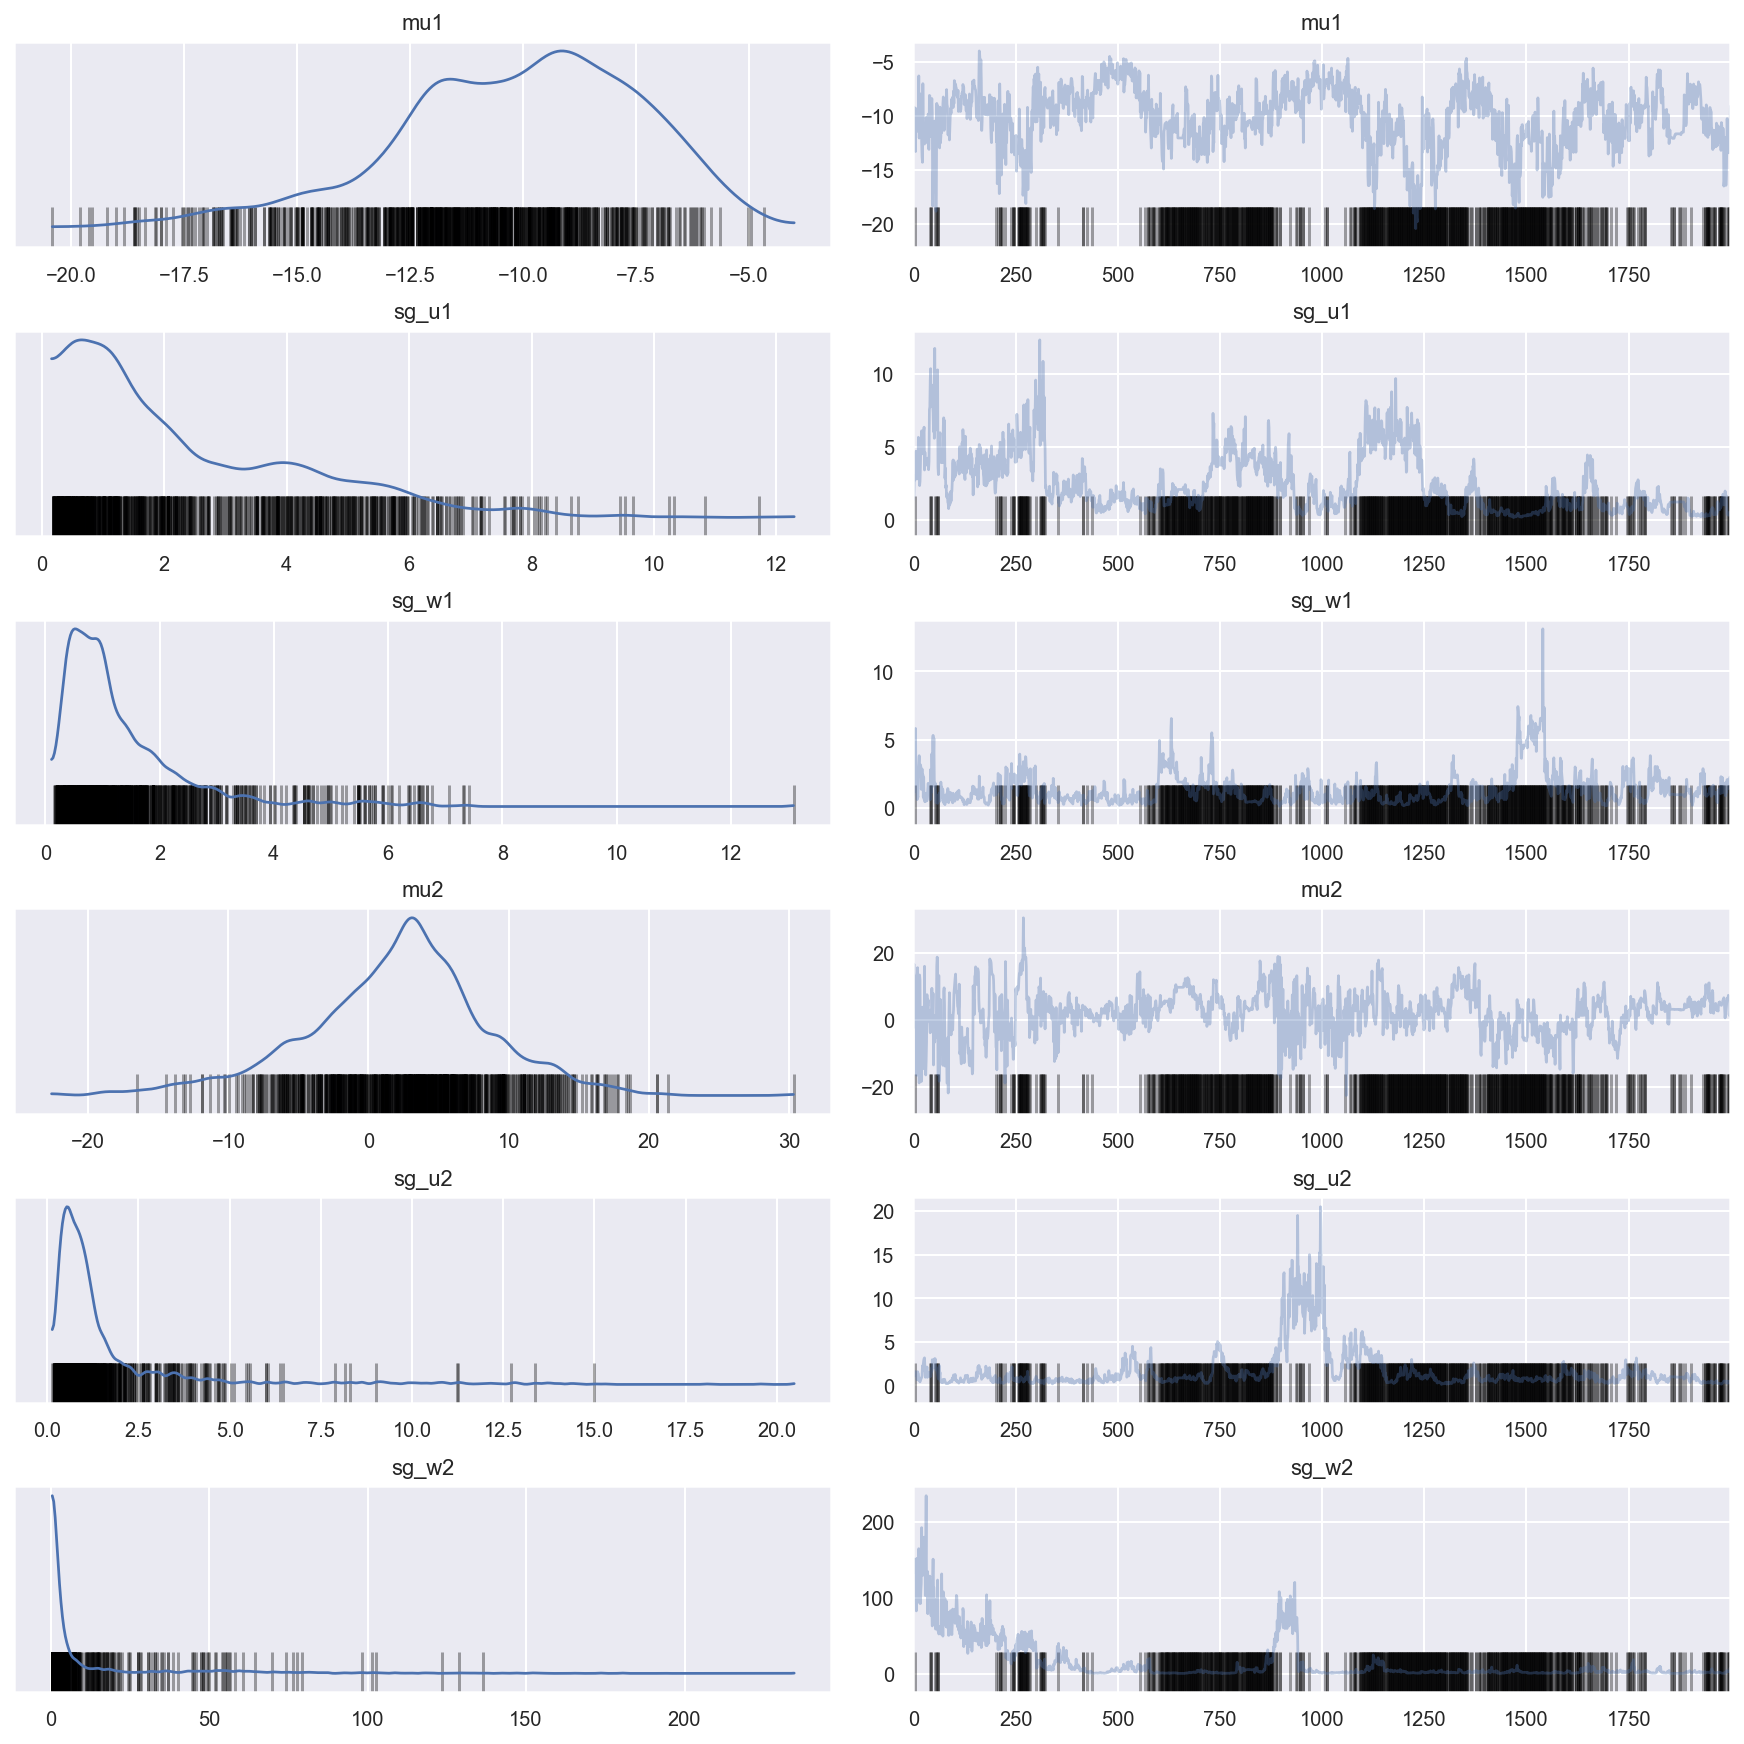

In [20]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu1', 'sg_u1', 'sg_w1', 'mu2', 'sg_u2', 'sg_w2']);

# Run with real data

In [21]:
df = pd.read_csv("data_full.csv", index_col=0)
df.drop(df[(df.domain != "active.fi") | (df.n_session_done != 14)].index, inplace=True)
df

,user,domain,condition,item,success,teacher_md,learner_md,psy_md,session,is_eval,ts_display,ts_reply,n_session_done
49739,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:37.666000+00:00,2020-09-30 17:51:41.042000+00:00,14
49740,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:42.081000+00:00,2020-09-30 17:51:43.910000+00:00,14
49741,goldfish@active.fi,active.fi,ThresholdCondition,1000,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:44.980000+00:00,2020-09-30 17:51:46.413000+00:00,14
49742,goldfish@active.fi,active.fi,ThresholdCondition,1506,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:47.476000+00:00,2020-09-30 17:51:50.206000+00:00,14
49743,goldfish@active.fi,active.fi,ThresholdCondition,190,True,leitner,NaN,grid,1900,False,2020-09-30 17:51:51.245000+00:00,2020-09-30 17:51:53.477000+00:00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147617,azalea@active.fi,active.fi,ThresholdCondition,179,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:21.524000+00:00,2020-10-08 05:52:31.640000+00:00,14
147618,azalea@active.fi,active.fi,ThresholdCondition,1071,False,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:32.658000+00:00,2020-10-08 05:52:45.959000+00:00,14
147619,azalea@active.fi,active.fi,ThresholdCondition,1196,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:48.143000+00:00,2020-10-08 05:52:51.527000+00:00,14
147620,azalea@active.fi,active.fi,ThresholdCondition,1282,True,threshold,exp_decay,grid,2571,True,2020-10-08 05:52:52.543000+00:00,2020-10-08 05:52:56.460000+00:00,14


In [22]:
df["ts_display"] = pd.to_datetime(df["ts_display"])  # str to datetime
df["ts_reply"] = pd.to_datetime(df["ts_reply"]) 

In [23]:
# Convert timestamps into seconds
beginning_history = pd.Timestamp("1970-01-01", tz="UTC")
df["timestamp"] = (df["ts_reply"] - beginning_history).dt.total_seconds().values

In [24]:
n_u = len(df.user.unique())
n_w = len(df.item.unique())
print(f"n_u={n_u}, n_w={n_w}" )

n_u=53, n_w=1998


In [25]:
# Copy actual item ID
df["item_id"] = df.item

In [26]:
for i, i_id in enumerate(df.item_id.unique()): 
    df.loc[df.item_id == i_id, 'item'] = i

In [27]:
print(df.item.min())
print(df.item.max())

0
1997


In [28]:
n_o_by_u = np.zeros(shape=n_u, dtype=int)
for u, (user, user_df) in enumerate(df.groupby("user")):
    n_o_by_u[u] = len(user_df) - len(user_df.item.unique()) # Do not count first presentation
n_o_max = n_o_by_u.max()
n_obs = n_o_by_u.sum()
print( f"n_o_max={n_o_max}")
print(f"n_o_min={n_o_by_u.min()}")
print(f"n_obs={n_obs}")

n_o_max=1404
n_o_min=1285
n_obs=70618


In [53]:
y = np.zeros(shape=n_obs, dtype=int)
d = np.zeros(shape=n_obs, dtype=float)
w = np.zeros(shape=n_obs, dtype=int)
r = np.zeros(shape=n_obs, dtype=int)
u = np.zeros(shape=n_obs, dtype=int)

idx = 0

for i_u, (user, user_df) in enumerate(df.groupby("user")):
    
    user_df = user_df.sort_values(by="timestamp")
    seen = user_df.item.unique()
    w_u = user_df.item.values      # Words
    ts_u = user_df.timestamp.values
    counts = {word: -1 for word in seen}
    last_pres = {word: None for word in seen}
    r_u = np.zeros(len(user_df))   # Number of repetitions
    d_u = np.zeros(r_u.shape)      # Time elapsed since last repetition 
    for i, word in enumerate(w_u):
        ts = ts_u[i]
        r_u[i] = counts[word]
        if last_pres[word] is not None:
            d_u[i] =  ts - last_pres[word]
        counts[word] += 1
        last_pres[word] = ts
    
    to_keep = r_u >= 0
    y_u = user_df.success.values[to_keep]
    r_u = r_u[to_keep]
    w_u = w_u[to_keep]
    d_u = d_u[to_keep]
    
    n_ou = len(y_u)
    # assert n_o_by_u[i_u] == n_ou
    
    y[idx:idx+n_ou] = y_u
    d[idx:idx+n_ou] = d_u
    w[idx:idx+n_ou] = w_u
    r[idx:idx+n_ou] = r_u
    u[idx:idx+n_ou] = i_u
    
    idx += n_ou

data = {'n_u': len(np.unique(u)), 'n_w': len(np.unique(w)), 'n_obs': len(y),
        'u': u, 'w': w, 
        'd': d, 'r': r,
        'y': y}

print("n obs", len(y))
print("mean success", y.mean())
print("y contains nan", np.isnan(y.sum()))
print("d contains nan", np.isnan(d.sum()))
print("r contains nan", np.isnan(r.sum()))
print("w contains nan", np.isnan(w.sum()))
print("u contains nan", np.isnan(u.sum()))
print("n_u is nan", np.isnan(n_u))
print("n_w is nan", np.isnan(n_w))
print("n_obs is nan", np.isnan(n_obs))
print("min/max d", np.min(d), np.max(d))
print("min/max r", np.min(r), np.max(r))

n obs 70618
mean success 0.8626837350250645
y contains nan False
d contains nan False
r contains nan False
w contains nan False
u contains nan False
n_u is nan False
n_w is nan False
n_obs is nan False
min/max d 1.7849998474121094 476175.66499996185
min/max r 0 213


In [61]:
from numpyro.infer.initialization import init_to_median

In [ ]:
nuts_kernel = NUTS(model, init_strategy=init_to_median())
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=1)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, **data)

In [ ]:
trace = az.from_numpyro(mcmc)
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);

In [ ]:
# mcmc.print_summary()